### Manipulation of Peaks de novo results of ETNP 2017 P2 trap samples (3) LC-MS/MS data using python.

Starting with:

    Peaks de novo results (.csv) of PTM-optimized database searches

Goal:

    Files with stripped (no PTMs) peptide lists and
    Columns with #'s of each modification in every sequence
    Column with stripped peptide lengths (# amino acids)

We don't have technical duplicates here, sadly, unlike the MED4 Pro samples. I exported PeaksDN search results CSVs into my ETNP 2017 git repo:

In [32]:
cd /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/

/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt


In [33]:
ls

ETNP-SKQ17-231-100m-0.3-JA2_DN50.csv
ETNP-SKQ17-233-265m-0.3-JA4_DN50.csv
ETNP-SKQ17-243-965m-0.3-JA14_DN50.csv
ETNP-SKQ17-273-965m-trap_DN50.csv
ETNP-SKQ17-273-965m-trap_DN50_stripped.csv
ETNP-SKQ17-273-965m-trap_DN50_stripped_peptides.txt
ETNP-SKQ17-273-965m-trap_DN80_stripped_peptides.txt
ETNP-SKQ17-278-265m-trap_DN50.csv
ETNP-SKQ17-278-265m-trap_DN50_stripped.csv
ETNP-SKQ17-278-265m-trap_DN50_stripped_peptides.txt
ETNP-SKQ17-278-265m-trap_DN80_stripped_peptides.txt
ETNP-SKQ17-378-100m-trap_DN50.csv
ETNP-SKQ17-378-100m-trap_DN50_stripped.csv


In [34]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

## 273: 965 m +P filtered on 0.3 um GF-75

In [35]:
#read the CSV into a datadrame we name 'comet' using the pandas read_csv function
peaks = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-273-965m-trap_DN50.csv")


#look at the dataframe
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
0,6,12978,20181003_4-19_273_965m_top.raw,LLYEEEK,7,97,7,462.2459,2,40.82,2450000.0,922.4647,13.6,NaN,99 99 97 99 99 98 95,LLYEEEK,CID
1,6,6251,20181003_4-19_273_965m_top.raw,EEDLER,6,97,6,395.6828,2,22.37,7190000.0,789.3504,0.9,NaN,99 100 97 98 99 92,EEDLER,CID
2,6,26188,20181003_4-19_273_965m_top.raw,LLEWLK,6,97,6,401.2476,2,69.91,927000.0,800.4796,1.3,NaN,98 97 98 95 98 96,LLEWLK,CID
3,6,8671,20181003_4-19_273_965m_top.raw,TEAPLNPK,8,97,8,435.2407,2,28.51,41300000.0,868.4654,1.6,NaN,99 100 100 95 97 94 97 95,TEAPLNPK,CID
4,6,6790,20181003_4-19_273_965m_top.raw,LYEETR,6,96,6,405.7037,2,23.57,4990000.0,809.3919,1.2,NaN,97 97 99 99 96 93,LYEETR,CID


The peptide column has the masses of modifications (e.g., 57.02 Da for carbamidomethylation of cysteine). We want to make new columns with all that information and make a column with only the 'stripped' peptide sequence that's just amino acids - this we can then align against other sequences, for example.

Modified residues were allowed for:

    fixed carbamodimethylation of cysteine 57.021464 C
    varialbe oxidation of methionine: 15.9949 M
    variable deamidation of asparagine, glumatine: 0.984016 NQ
    variable hydroxylation of lysine and proline: 15.9949 KP
    variable methylation of lysine and arginine: 14.015650 KR

We'll then write this manipulated dataframe to a new file.

In [36]:
# use a count function to enumerate the # of ccarbamidomethylated C's in each peptide
peaks['c-carb'] = peaks['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks['m-oxid'] = peaks['Peptide'].str.count("15.99")

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks['n-deam'] = peaks['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks['n-deam'] = peaks['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks['q-deam'] = peaks['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of hydroxylated K's in each peptide
peaks['k-hydr'] = peaks['Peptide'].apply(lambda x: x.count('K(+15.99)'))

# use a count function to enumerate the # of hydroxylated P's in each peptide
peaks['p-hydr'] = peaks['Peptide'].apply(lambda x: x.count('P(+15.99)'))

# use a count function to enumerate the # of methylated K's in each peptide
peaks['k-meth'] = peaks['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks['r-meth'] = peaks['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks['stripped peptide'] = peaks['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks['stripped length'] = peaks['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks['ptm-total'] = peaks['c-carb'] + peaks['m-oxid'] + peaks['n-deam'] + peaks['q-deam'] + peaks['k-hydr'] + peaks['p-hydr'] + peaks['k-meth'] + peaks['r-meth']

# total the number of modifications in sequence relative to # of AAs
peaks['ptm-norm'] = peaks['ptm-total'] / peaks['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-273-965m-trap_DN50_stripped.csv")


# check out the results
peaks.head(20)

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,n-deam,q-deam,k-hydr,p-hydr,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm
0,6,12978,20181003_4-19_273_965m_top.raw,LLYEEEK,7,97,7,462.2459,2,40.82,...,0,0,0,0,0,0,LLYEEEK,7,0,0.000000
1,6,6251,20181003_4-19_273_965m_top.raw,EEDLER,6,97,6,395.6828,2,22.37,...,0,0,0,0,0,0,EEDLER,6,0,0.000000
2,6,26188,20181003_4-19_273_965m_top.raw,LLEWLK,6,97,6,401.2476,2,69.91,...,0,0,0,0,0,0,LLEWLK,6,0,0.000000
3,6,8671,20181003_4-19_273_965m_top.raw,TEAPLNPK,8,97,8,435.2407,2,28.51,...,0,0,0,0,0,0,TEAPLNPK,8,0,0.000000
4,6,6790,20181003_4-19_273_965m_top.raw,LYEETR,6,96,6,405.7037,2,23.57,...,0,0,0,0,0,0,LYEETR,6,0,0.000000
5,6,26878,20181003_4-19_273_965m_top.raw,WLSLYLPK,8,96,8,510.2927,2,71.16,...,0,0,0,0,0,0,WLSLYLPK,8,0,0.000000
6,6,27770,20181003_4-19_273_965m_top.raw,FLELLK,6,96,6,381.7418,2,72.75,...,0,0,0,0,0,0,FLELLK,6,0,0.000000
7,6,16792,20181003_4-19_273_965m_top.raw,FEDTNLAALHAK,12,96,12,665.3448,2,50.59,...,0,0,0,0,0,0,FEDTNLAALHAK,12,0,0.000000
8,6,5592,20181003_4-19_273_965m_top.raw,ALEQEEAK,8,96,8,459.2321,2,20.95,...,0,0,0,0,0,0,ALEQEEAK,8,0,0.000000
9,6,9063,20181003_4-19_273_965m_top.raw,EATGALKAR,9,96,9,458.7648,2,29.62,...,0,0,0,0,0,0,EATGALKAR,9,0,0.000000


### Visualizing the results:

In [37]:
print("ALC max: ", peaks['ALC (%)'].max())
print("ALC min: ", peaks['ALC (%)'].min())

ALC max:  97
ALC min:  50


In [38]:
# making evenly spaced bins for the ALC data based on the min and max, called above
bins = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']

# use pandas cut function to do the binning itself
peaks['binned'] = pd.cut(peaks['ALC (%)'], bins=bins, labels=labels)


peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,q-deam,k-hydr,p-hydr,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm,binned
0,6,12978,20181003_4-19_273_965m_top.raw,LLYEEEK,7,97,7,462.2459,2,40.82,...,0,0,0,0,0,LLYEEEK,7,0,0.0,95-100
1,6,6251,20181003_4-19_273_965m_top.raw,EEDLER,6,97,6,395.6828,2,22.37,...,0,0,0,0,0,EEDLER,6,0,0.0,95-100
2,6,26188,20181003_4-19_273_965m_top.raw,LLEWLK,6,97,6,401.2476,2,69.91,...,0,0,0,0,0,LLEWLK,6,0,0.0,95-100
3,6,8671,20181003_4-19_273_965m_top.raw,TEAPLNPK,8,97,8,435.2407,2,28.51,...,0,0,0,0,0,TEAPLNPK,8,0,0.0,95-100
4,6,6790,20181003_4-19_273_965m_top.raw,LYEETR,6,96,6,405.7037,2,23.57,...,0,0,0,0,0,LYEETR,6,0,0.0,95-100


        Total PTMs  Cys carb.  Met oxi.  Asp deam.  Glut deam.  Lys hydr  \
50-55         4260        369      1544        190           4       458   
55-60         3366        294      1270        162           3       336   
60-65         2425        170       906        132           6       205   
65-70         2159        168       785        141           3       165   
70-75         1493         94       553        124          12       125   
75-80         1010         58       362        107          14        88   
80-85          649         38       236         86           6        48   
85-90          392         31       132         56           5        22   
90-95          122         18        28         34           6         4   
95-100           0          0         0          0           0         0   

        Pro hydr  Lys meth.  Arg meth.  
50-55        632        417        646  
55-60        535        287        479  
60-65        428        209        369  

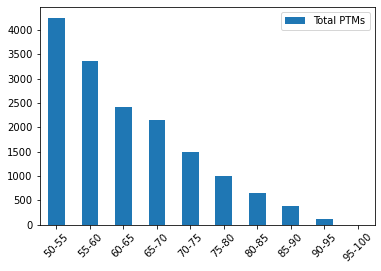

In [39]:
# plotting histograms of PTMs using matplotlib

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys hydr': [peaks.groupby('binned')['k-hydr'].sum()['50-55'], peaks.groupby('binned')['k-hydr'].sum()['55-60'], peaks.groupby('binned')['k-hydr'].sum()['60-65'], peaks.groupby('binned')['k-hydr'].sum()['65-70'], peaks.groupby('binned')['k-hydr'].sum()['70-75'], peaks.groupby('binned')['k-hydr'].sum()['75-80'], peaks.groupby('binned')['k-hydr'].sum()['80-85'], peaks.groupby('binned')['k-hydr'].sum()['85-90'], peaks.groupby('binned')['k-hydr'].sum()['90-95'], peaks.groupby('binned')['k-hydr'].sum()['95-100']],
        'Pro hydr': [peaks.groupby('binned')['p-hydr'].sum()['50-55'], peaks.groupby('binned')['p-hydr'].sum()['55-60'], peaks.groupby('binned')['p-hydr'].sum()['60-65'], peaks.groupby('binned')['p-hydr'].sum()['65-70'], peaks.groupby('binned')['p-hydr'].sum()['70-75'], peaks.groupby('binned')['p-hydr'].sum()['75-80'], peaks.groupby('binned')['p-hydr'].sum()['80-85'], peaks.groupby('binned')['p-hydr'].sum()['85-90'], peaks.groupby('binned')['p-hydr'].sum()['90-95'], peaks.groupby('binned')['p-hydr'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys hydr', 'Pro hydr', 'Lys meth.', 'Arg meth.'], index=index)
print (peaksbin)
plt = peaksbin.plot.bar(y='Total PTMs', rot=45)
plt

Text(0.5, 1.0, 'Arginine methylation')

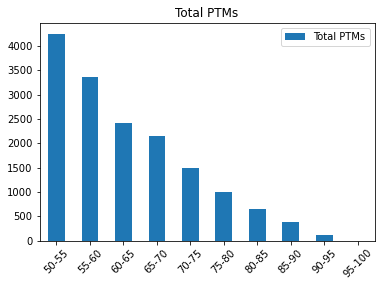

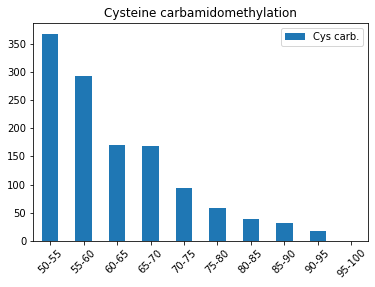

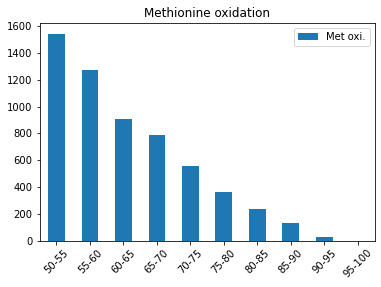

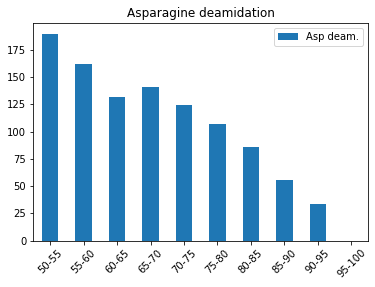

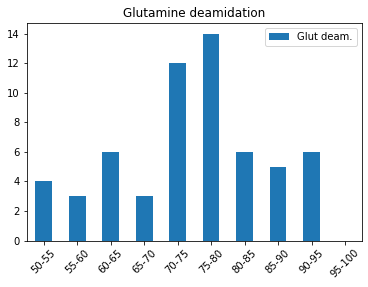

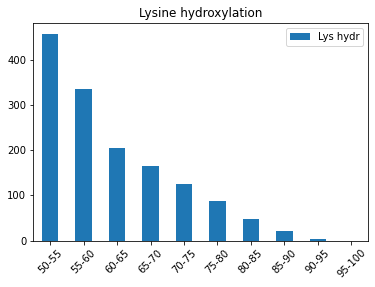

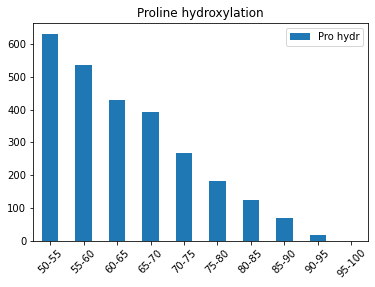

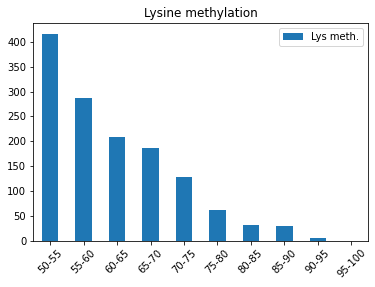

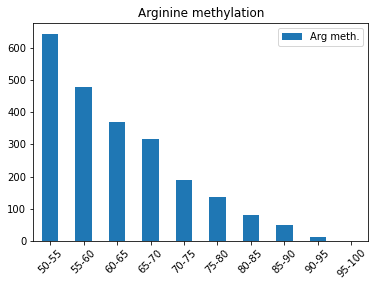

In [40]:
# bar plots of binned PTM data

# plotting histograms of PTMs using matplotlib

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys hydr': [peaks.groupby('binned')['k-hydr'].sum()['50-55'], peaks.groupby('binned')['k-hydr'].sum()['55-60'], peaks.groupby('binned')['k-hydr'].sum()['60-65'], peaks.groupby('binned')['k-hydr'].sum()['65-70'], peaks.groupby('binned')['k-hydr'].sum()['70-75'], peaks.groupby('binned')['k-hydr'].sum()['75-80'], peaks.groupby('binned')['k-hydr'].sum()['80-85'], peaks.groupby('binned')['k-hydr'].sum()['85-90'], peaks.groupby('binned')['k-hydr'].sum()['90-95'], peaks.groupby('binned')['k-hydr'].sum()['95-100']],
        'Pro hydr': [peaks.groupby('binned')['p-hydr'].sum()['50-55'], peaks.groupby('binned')['p-hydr'].sum()['55-60'], peaks.groupby('binned')['p-hydr'].sum()['60-65'], peaks.groupby('binned')['p-hydr'].sum()['65-70'], peaks.groupby('binned')['p-hydr'].sum()['70-75'], peaks.groupby('binned')['p-hydr'].sum()['75-80'], peaks.groupby('binned')['p-hydr'].sum()['80-85'], peaks.groupby('binned')['p-hydr'].sum()['85-90'], peaks.groupby('binned')['p-hydr'].sum()['90-95'], peaks.groupby('binned')['p-hydr'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys hydr', 'Pro hydr', 'Lys meth.', 'Arg meth.'], index=index)

ax1 = peaksbin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = peaksbin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = peaksbin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = peaksbin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = peaksbin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = peaksbin.plot.bar(y='Lys hydr', rot=45)
ax6.set_title('Lysine hydroxylation')

ax7 = peaksbin.plot.bar(y='Pro hydr', rot=45)
ax7.set_title('Proline hydroxylation')

ax8 = peaksbin.plot.bar(y='Lys meth.', rot=45)
ax8.set_title('Lysine methylation')

ax9 = peaksbin.plot.bar(y='Arg meth.', rot=45)
ax9.set_title('Arginine methylation')


In [41]:
# keep only peptide column >50% ALC
pep = peaks[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-273-965m-trap_DN50_stripped_peptides.txt", header=False, index=False)


# look

print("# of DN peptide >50% ALC", len(pep))
pep.head()

# of DN peptide >50% ALC 8727


,stripped peptide
0,LLYEEEK
1,EEDLER
2,LLEWLK
3,TEAPLNPK
4,LYEETR


In [42]:
# keep only peptides  >80% ALC
peaks80 = peaks.loc[peaks['ALC (%)'] >= 80]

# see how many rows and double check
# peaks80.head(-10)

# keep only peptide column 
pep80 = peaks80[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-273-965m-trap_DN80_stripped_peptides.txt", header=False, index=False)


print("# of DN peptide >80% ALC", len(pep))
pep.head()

# of DN peptide >80% ALC 8727


,stripped peptide
0,LLYEEEK
1,EEDLER
2,LLEWLK
3,TEAPLNPK
4,LYEETR


## 278: 265 m +P filtered on 0.3 um GF-75

In [14]:
#read the CSV into a datadrame we name 'comet' using the pandas read_csv function
peaks = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-278-265m-trap_DN50.csv")


#look at the dataframe
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
0,5,14925,20181004_4-19_265m_topP_278_90min.raw,M(+15.99)TAEELKK,8,97,8,483.2513,2,41.26,21600000.0,964.4899,-2.0,Oxidation (M),97 98 97 99 99 98 99 96,M(+15.99)TAEELKK,CID
1,5,6540,20181004_4-19_265m_topP_278_90min.raw,EEDLER,6,97,6,395.6833,2,22.82,8180000.0,789.3504,2.1,NaN,99 99 97 98 99 93,EEDLER,CID
2,5,13192,20181004_4-19_265m_topP_278_90min.raw,SC(+57.02)DWPK,6,97,6,396.6714,2,37.44,4220000.0,791.3272,1.3,Carbamidomethylation,98 99 99 97 96 96,SC(+57.02)DWPK,CID
3,5,6054,20181004_4-19_265m_topP_278_90min.raw,WLEEDK,6,97,6,410.1956,2,21.80,920000.0,818.3810,-5.3,NaN,97 99 100 98 96 94,WLEEDK,CID
4,5,9250,20181004_4-19_265m_topP_278_90min.raw,TEAPLNPK,8,97,8,435.2410,2,28.76,46800000.0,868.4654,2.3,NaN,99 100 100 94 97 95 97 98,TEAPLNPK,CID


In [15]:
# use a count function to enumerate the # of ccarbamidomethylated C's in each peptide
peaks['c-carb'] = peaks['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks['m-oxid'] = peaks['Peptide'].str.count("15.99")

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks['n-deam'] = peaks['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks['n-deam'] = peaks['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks['q-deam'] = peaks['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of hydroxylated K's in each peptide
peaks['k-hydr'] = peaks['Peptide'].apply(lambda x: x.count('K(+15.99)'))

# use a count function to enumerate the # of hydroxylated P's in each peptide
peaks['p-hydr'] = peaks['Peptide'].apply(lambda x: x.count('P(+15.99)'))

# use a count function to enumerate the # of methylated K's in each peptide
peaks['k-meth'] = peaks['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks['r-meth'] = peaks['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks['stripped peptide'] = peaks['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks['stripped length'] = peaks['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks['ptm-total'] = peaks['c-carb'] + peaks['m-oxid'] + peaks['n-deam'] + peaks['q-deam'] + peaks['k-hydr'] + peaks['p-hydr'] + peaks['k-meth'] + peaks['r-meth']

# total the number of modifications in sequence relative to # of AAs
peaks['ptm-norm'] = peaks['ptm-total'] / peaks['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-278-265m-trap_DN50_stripped.csv")


# check out the results
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,n-deam,q-deam,k-hydr,p-hydr,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm
0,5,14925,20181004_4-19_265m_topP_278_90min.raw,M(+15.99)TAEELKK,8,97,8,483.2513,2,41.26,...,0,0,0,0,0,0,MTAEELKK,8,1,0.125000
1,5,6540,20181004_4-19_265m_topP_278_90min.raw,EEDLER,6,97,6,395.6833,2,22.82,...,0,0,0,0,0,0,EEDLER,6,0,0.000000
2,5,13192,20181004_4-19_265m_topP_278_90min.raw,SC(+57.02)DWPK,6,97,6,396.6714,2,37.44,...,0,0,0,0,0,0,SCDWPK,6,1,0.166667
3,5,6054,20181004_4-19_265m_topP_278_90min.raw,WLEEDK,6,97,6,410.1956,2,21.80,...,0,0,0,0,0,0,WLEEDK,6,0,0.000000
4,5,9250,20181004_4-19_265m_topP_278_90min.raw,TEAPLNPK,8,97,8,435.2410,2,28.76,...,0,0,0,0,0,0,TEAPLNPK,8,0,0.000000


### Visualizing the results:

In [16]:
print("ALC max: ", peaks['ALC (%)'].max())
print("ALC min: ", peaks['ALC (%)'].min())

ALC max:  97
ALC min:  50


In [17]:
# making evenly spaced bins for the ALC data based on the min and max, called above
bins = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']

# use pandas cut function to do the binning itself
peaks['binned'] = pd.cut(peaks['ALC (%)'], bins=bins, labels=labels)


peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,q-deam,k-hydr,p-hydr,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm,binned
0,5,14925,20181004_4-19_265m_topP_278_90min.raw,M(+15.99)TAEELKK,8,97,8,483.2513,2,41.26,...,0,0,0,0,0,MTAEELKK,8,1,0.125000,95-100
1,5,6540,20181004_4-19_265m_topP_278_90min.raw,EEDLER,6,97,6,395.6833,2,22.82,...,0,0,0,0,0,EEDLER,6,0,0.000000,95-100
2,5,13192,20181004_4-19_265m_topP_278_90min.raw,SC(+57.02)DWPK,6,97,6,396.6714,2,37.44,...,0,0,0,0,0,SCDWPK,6,1,0.166667,95-100
3,5,6054,20181004_4-19_265m_topP_278_90min.raw,WLEEDK,6,97,6,410.1956,2,21.80,...,0,0,0,0,0,WLEEDK,6,0,0.000000,95-100
4,5,9250,20181004_4-19_265m_topP_278_90min.raw,TEAPLNPK,8,97,8,435.2410,2,28.76,...,0,0,0,0,0,TEAPLNPK,8,0,0.000000,95-100


        Total PTMs  Cys carb.  Met oxi.  Asp deam.  Glut deam.  Lys hydr  \
50-55         4486        456      1671        199           3       418   
55-60         4160        348      1559        241           7       402   
60-65         3461        303      1288        200           8       300   
65-70         2827        257      1021        170           6       212   
70-75         2259        173       825        169           9       166   
75-80         1639        135       589        160           8       123   
80-85          996         74       334        121          17        66   
85-90          627         47       192         97           8        30   
90-95          194         27        49         51           1         9   
95-100          24          3         6          5           1         0   

        Pro hydr  Lys meth.  Arg meth.  
50-55        713        411        615  
55-60        703        349        551  
60-65        588        280        494  

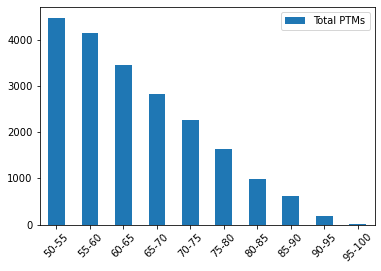

In [18]:
# plotting histograms of PTMs using matplotlib

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys hydr': [peaks.groupby('binned')['k-hydr'].sum()['50-55'], peaks.groupby('binned')['k-hydr'].sum()['55-60'], peaks.groupby('binned')['k-hydr'].sum()['60-65'], peaks.groupby('binned')['k-hydr'].sum()['65-70'], peaks.groupby('binned')['k-hydr'].sum()['70-75'], peaks.groupby('binned')['k-hydr'].sum()['75-80'], peaks.groupby('binned')['k-hydr'].sum()['80-85'], peaks.groupby('binned')['k-hydr'].sum()['85-90'], peaks.groupby('binned')['k-hydr'].sum()['90-95'], peaks.groupby('binned')['k-hydr'].sum()['95-100']],
        'Pro hydr': [peaks.groupby('binned')['p-hydr'].sum()['50-55'], peaks.groupby('binned')['p-hydr'].sum()['55-60'], peaks.groupby('binned')['p-hydr'].sum()['60-65'], peaks.groupby('binned')['p-hydr'].sum()['65-70'], peaks.groupby('binned')['p-hydr'].sum()['70-75'], peaks.groupby('binned')['p-hydr'].sum()['75-80'], peaks.groupby('binned')['p-hydr'].sum()['80-85'], peaks.groupby('binned')['p-hydr'].sum()['85-90'], peaks.groupby('binned')['p-hydr'].sum()['90-95'], peaks.groupby('binned')['p-hydr'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys hydr', 'Pro hydr', 'Lys meth.', 'Arg meth.'], index=index)
print (peaksbin)
plt = peaksbin.plot.bar(y='Total PTMs', rot=45)
plt

Text(0.5, 1.0, 'Arginine methylation')

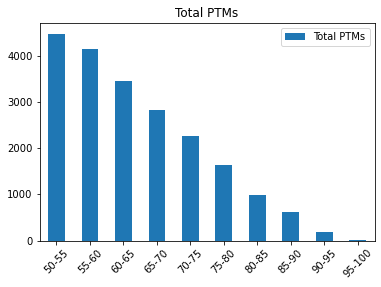

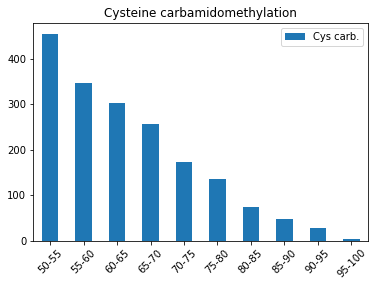

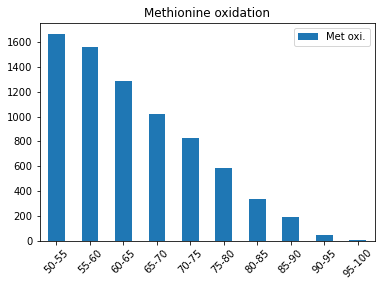

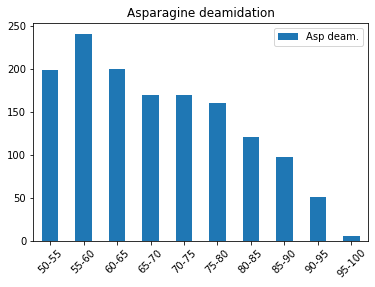

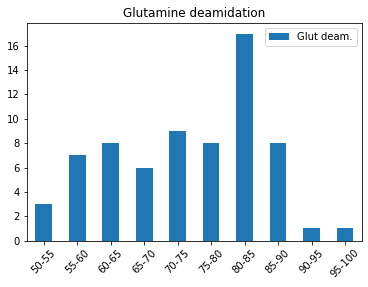

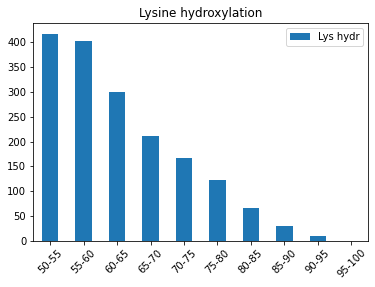

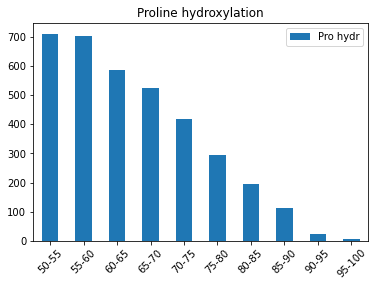

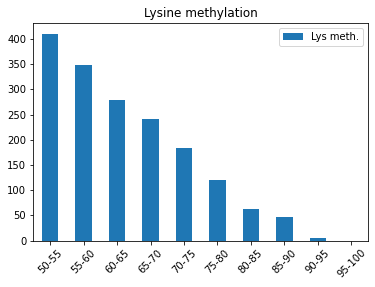

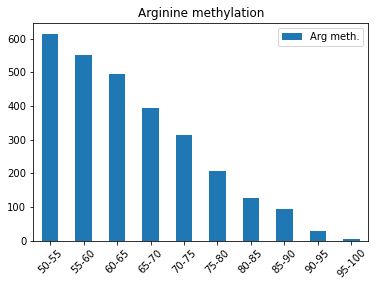

In [19]:
# bar plots of binned PTM data

# plotting histograms of PTMs using matplotlib

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys hydr': [peaks.groupby('binned')['k-hydr'].sum()['50-55'], peaks.groupby('binned')['k-hydr'].sum()['55-60'], peaks.groupby('binned')['k-hydr'].sum()['60-65'], peaks.groupby('binned')['k-hydr'].sum()['65-70'], peaks.groupby('binned')['k-hydr'].sum()['70-75'], peaks.groupby('binned')['k-hydr'].sum()['75-80'], peaks.groupby('binned')['k-hydr'].sum()['80-85'], peaks.groupby('binned')['k-hydr'].sum()['85-90'], peaks.groupby('binned')['k-hydr'].sum()['90-95'], peaks.groupby('binned')['k-hydr'].sum()['95-100']],
        'Pro hydr': [peaks.groupby('binned')['p-hydr'].sum()['50-55'], peaks.groupby('binned')['p-hydr'].sum()['55-60'], peaks.groupby('binned')['p-hydr'].sum()['60-65'], peaks.groupby('binned')['p-hydr'].sum()['65-70'], peaks.groupby('binned')['p-hydr'].sum()['70-75'], peaks.groupby('binned')['p-hydr'].sum()['75-80'], peaks.groupby('binned')['p-hydr'].sum()['80-85'], peaks.groupby('binned')['p-hydr'].sum()['85-90'], peaks.groupby('binned')['p-hydr'].sum()['90-95'], peaks.groupby('binned')['p-hydr'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys hydr', 'Pro hydr', 'Lys meth.', 'Arg meth.'], index=index)

ax1 = peaksbin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = peaksbin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = peaksbin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = peaksbin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = peaksbin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = peaksbin.plot.bar(y='Lys hydr', rot=45)
ax6.set_title('Lysine hydroxylation')

ax7 = peaksbin.plot.bar(y='Pro hydr', rot=45)
ax7.set_title('Proline hydroxylation')

ax8 = peaksbin.plot.bar(y='Lys meth.', rot=45)
ax8.set_title('Lysine methylation')

ax9 = peaksbin.plot.bar(y='Arg meth.', rot=45)
ax9.set_title('Arginine methylation')


In [30]:
# keep only peptide column >50% ALC
pep = peaks[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-278-265m-trap_DN50_stripped_peptides.txt", header=False, index=False)


# look

print("# of DN peptide >50% ALC", len(pep))
pep.head()

# of DN peptide >50% ALC 1590


,stripped peptide
0,VVEEAPK
1,SLEAESR
2,EEDLER
3,TEEAVEEK
4,ELAGNAAR


In [31]:
# keep only peptides  >80% ALC
peaks80 = peaks.loc[peaks['ALC (%)'] >= 80]

# see how many rows and double check
# peaks80.head(-10)

# keep only peptide column 
pep80 = peaks80[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-278-265m-trap_DN80_stripped_peptides.txt", header=False, index=False)


print("# of DN peptide >80% ALC", len(pep))
pep.head()

# of DN peptide >80% ALC 1590


,stripped peptide
0,VVEEAPK
1,SLEAESR
2,EEDLER
3,TEEAVEEK
4,ELAGNAAR


In [48]:
# now there are the orignial csvs, 
# the stripped peptide version of those, 
# and the txt only stripped peptides for >50 and >80% ALC
!ls /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/

RAL95_MED2_trypsin_1_PTMopt_DN50.csv
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped.csv
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped_peptides.txt
RAL95_MED2_trypsin_1_PTMopt_DN50_stripped_work.ods
RAL95_MED2_trypsin_1_PTMopt_DN80_stripped_peptides.txt
RAL95_MED2_trypsin_2_PTMopt_DN50.csv
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped.csv
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped_peptides.txt
RAL95_MED2_trypsin_2_PTMopt_DN50_stripped_work.ods
RAL95_MED2_trypsin_2_PTMopt_DN80_stripped_peptides.txt


## 378: 100 m +P filtered on 0.3 um GF-75

In [20]:
#read the CSV into a datadrame we name 'comet' using the pandas read_csv function
peaks = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-378-100m-trap_DN50.csv")


#look at the dataframe
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,Area,Mass,ppm,PTM,local confidence (%),tag (>=0%),mode
0,4,4564,20181214_378_etnp2017_100m_trap.raw,VVEEAPK,7,99,7,386.2155,2,17.85,800000.0,770.4174,-1.1,NaN,99 99 100 100 99 99 99,VVEEAPK,CID
1,4,4574,20181214_378_etnp2017_100m_trap.raw,SLEAESR,7,98,7,396.1982,2,17.88,513000.0,790.3821,-0.4,NaN,98 99 100 99 99 98 96,SLEAESR,CID
2,4,4982,20181214_378_etnp2017_100m_trap.raw,EEDLER,6,98,6,395.6826,2,19.14,245000.0,789.3504,0.3,NaN,100 100 98 99 99 95,EEDLER,CID
3,4,3812,20181214_378_etnp2017_100m_trap.raw,TEEAVEEK,8,98,8,467.7217,2,15.60,232000.0,933.4291,-0.2,NaN,99 100 100 99 97 99 99 90,TEEAVEEK,CID
4,4,3992,20181214_378_etnp2017_100m_trap.raw,ELAGNAAR,8,97,8,401.2144,2,16.13,485000.0,800.4140,0.3,NaN,98 96 99 97 98 99 99 98,ELAGNAAR,CID


In [22]:
# use a count function to enumerate the # of ccarbamidomethylated C's in each peptide
peaks['c-carb'] = peaks['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks['m-oxid'] = peaks['Peptide'].str.count("15.99")

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks['n-deam'] = peaks['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks['n-deam'] = peaks['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks['q-deam'] = peaks['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of hydroxylated K's in each peptide
peaks['k-hydr'] = peaks['Peptide'].apply(lambda x: x.count('K(+15.99)'))

# use a count function to enumerate the # of hydroxylated P's in each peptide
peaks['p-hydr'] = peaks['Peptide'].apply(lambda x: x.count('P(+15.99)'))

# use a count function to enumerate the # of methylated K's in each peptide
peaks['k-meth'] = peaks['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks['r-meth'] = peaks['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks['stripped peptide'] = peaks['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks['stripped length'] = peaks['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks['ptm-total'] = peaks['c-carb'] + peaks['m-oxid'] + peaks['n-deam'] + peaks['q-deam'] + peaks['k-hydr'] + peaks['p-hydr'] + peaks['k-meth'] + peaks['r-meth']

# total the number of modifications in sequence relative to # of AAs
peaks['ptm-norm'] = peaks['ptm-total'] / peaks['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-378-100m-trap_DN50_stripped.csv")


# check out the results
peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,n-deam,q-deam,k-hydr,p-hydr,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm
0,4,4564,20181214_378_etnp2017_100m_trap.raw,VVEEAPK,7,99,7,386.2155,2,17.85,...,0,0,0,0,0,0,VVEEAPK,7,0,0.0
1,4,4574,20181214_378_etnp2017_100m_trap.raw,SLEAESR,7,98,7,396.1982,2,17.88,...,0,0,0,0,0,0,SLEAESR,7,0,0.0
2,4,4982,20181214_378_etnp2017_100m_trap.raw,EEDLER,6,98,6,395.6826,2,19.14,...,0,0,0,0,0,0,EEDLER,6,0,0.0
3,4,3812,20181214_378_etnp2017_100m_trap.raw,TEEAVEEK,8,98,8,467.7217,2,15.60,...,0,0,0,0,0,0,TEEAVEEK,8,0,0.0
4,4,3992,20181214_378_etnp2017_100m_trap.raw,ELAGNAAR,8,97,8,401.2144,2,16.13,...,0,0,0,0,0,0,ELAGNAAR,8,0,0.0


### Visualizing the results

In [23]:
print("ALC max: ", peaks['ALC (%)'].max())
print("ALC min: ", peaks['ALC (%)'].min())

ALC max:  99
ALC min:  50


In [24]:
# making evenly spaced bins for the ALC data based on the min and max, called above
bins = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']

# use pandas cut function to do the binning itself
peaks['binned'] = pd.cut(peaks['ALC (%)'], bins=bins, labels=labels)


peaks.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,q-deam,k-hydr,p-hydr,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm,binned
0,4,4564,20181214_378_etnp2017_100m_trap.raw,VVEEAPK,7,99,7,386.2155,2,17.85,...,0,0,0,0,0,VVEEAPK,7,0,0.0,95-100
1,4,4574,20181214_378_etnp2017_100m_trap.raw,SLEAESR,7,98,7,396.1982,2,17.88,...,0,0,0,0,0,SLEAESR,7,0,0.0,95-100
2,4,4982,20181214_378_etnp2017_100m_trap.raw,EEDLER,6,98,6,395.6826,2,19.14,...,0,0,0,0,0,EEDLER,6,0,0.0,95-100
3,4,3812,20181214_378_etnp2017_100m_trap.raw,TEEAVEEK,8,98,8,467.7217,2,15.60,...,0,0,0,0,0,TEEAVEEK,8,0,0.0,95-100
4,4,3992,20181214_378_etnp2017_100m_trap.raw,ELAGNAAR,8,97,8,401.2144,2,16.13,...,0,0,0,0,0,ELAGNAAR,8,0,0.0,95-100


        Total PTMs  Cys carb.  Met oxi.  Asp deam.  Glut deam.  Lys hydr  \
50-55          478         61       178         29           1        48   
55-60          368         47       129         19           0        35   
60-65          319         20       111         26           1        27   
65-70          372         32       131         29           1        27   
70-75          256         26        90         15           5        28   
75-80          212         13        70         22           1        16   
80-85          195          5        66         18           6        16   
85-90          133          4        38         22           5         7   
90-95           85          9        26         20           2         2   
95-100          19          3         2         11           2         0   

        Pro hydr  Lys meth.  Arg meth.  
50-55         68         44         49  
55-60         55         50         33  
60-65         57         37         40  

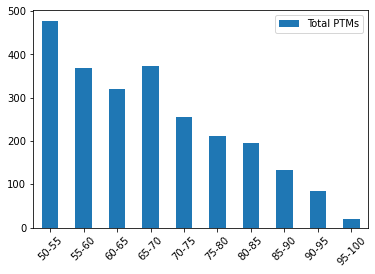

In [25]:
# plotting histograms of PTMs using matplotlib

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys hydr': [peaks.groupby('binned')['k-hydr'].sum()['50-55'], peaks.groupby('binned')['k-hydr'].sum()['55-60'], peaks.groupby('binned')['k-hydr'].sum()['60-65'], peaks.groupby('binned')['k-hydr'].sum()['65-70'], peaks.groupby('binned')['k-hydr'].sum()['70-75'], peaks.groupby('binned')['k-hydr'].sum()['75-80'], peaks.groupby('binned')['k-hydr'].sum()['80-85'], peaks.groupby('binned')['k-hydr'].sum()['85-90'], peaks.groupby('binned')['k-hydr'].sum()['90-95'], peaks.groupby('binned')['k-hydr'].sum()['95-100']],
        'Pro hydr': [peaks.groupby('binned')['p-hydr'].sum()['50-55'], peaks.groupby('binned')['p-hydr'].sum()['55-60'], peaks.groupby('binned')['p-hydr'].sum()['60-65'], peaks.groupby('binned')['p-hydr'].sum()['65-70'], peaks.groupby('binned')['p-hydr'].sum()['70-75'], peaks.groupby('binned')['p-hydr'].sum()['75-80'], peaks.groupby('binned')['p-hydr'].sum()['80-85'], peaks.groupby('binned')['p-hydr'].sum()['85-90'], peaks.groupby('binned')['p-hydr'].sum()['90-95'], peaks.groupby('binned')['p-hydr'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys hydr', 'Pro hydr', 'Lys meth.', 'Arg meth.'], index=index)
print (peaksbin)
plt = peaksbin.plot.bar(y='Total PTMs', rot=45)
plt

Text(0.5, 1.0, 'Arginine methylation')

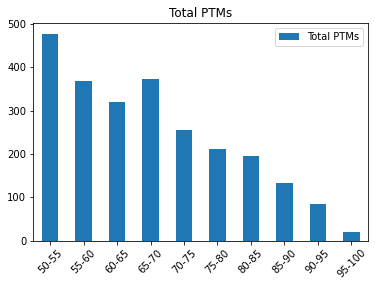

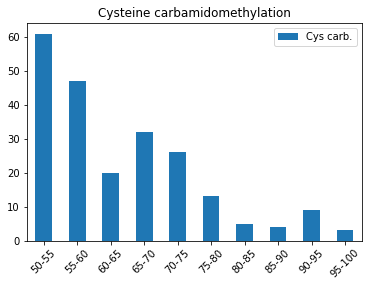

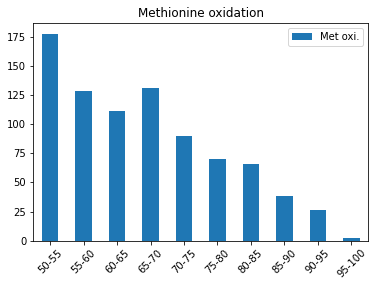

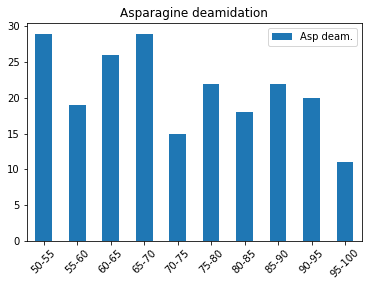

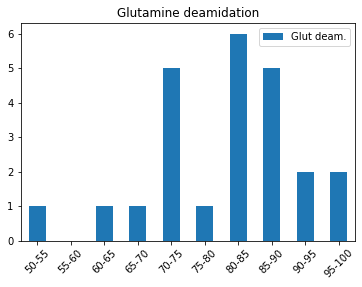

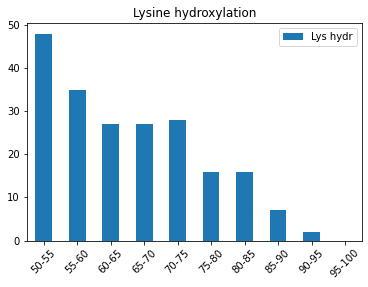

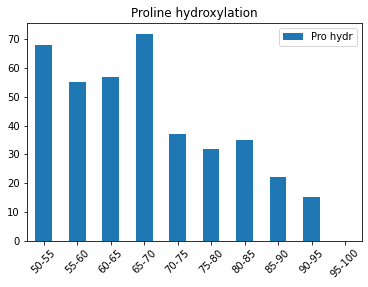

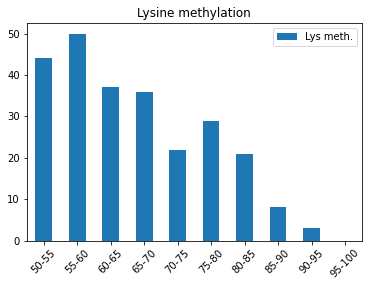

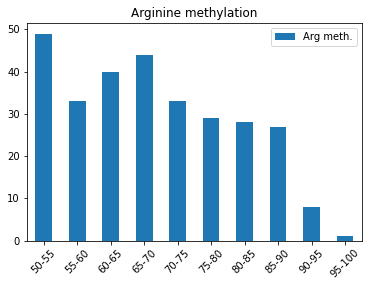

In [26]:
# bar plots of binned PTM data

# plotting histograms of PTMs using matplotlib

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks.groupby('binned')['ptm-total'].sum()['50-55'], peaks.groupby('binned')['ptm-total'].sum()['55-60'], peaks.groupby('binned')['ptm-total'].sum()['60-65'], peaks.groupby('binned')['ptm-total'].sum()['65-70'], peaks.groupby('binned')['ptm-total'].sum()['70-75'], peaks.groupby('binned')['ptm-total'].sum()['75-80'], peaks.groupby('binned')['ptm-total'].sum()['80-85'], peaks.groupby('binned')['ptm-total'].sum()['85-90'], peaks.groupby('binned')['ptm-total'].sum()['90-95'], peaks.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks.groupby('binned')['c-carb'].sum()['50-55'], peaks.groupby('binned')['c-carb'].sum()['55-60'], peaks.groupby('binned')['c-carb'].sum()['60-65'], peaks.groupby('binned')['c-carb'].sum()['65-70'], peaks.groupby('binned')['c-carb'].sum()['70-75'], peaks.groupby('binned')['c-carb'].sum()['75-80'], peaks.groupby('binned')['c-carb'].sum()['80-85'], peaks.groupby('binned')['c-carb'].sum()['85-90'], peaks.groupby('binned')['c-carb'].sum()['90-95'], peaks.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks.groupby('binned')['m-oxid'].sum()['50-55'], peaks.groupby('binned')['m-oxid'].sum()['55-60'], peaks.groupby('binned')['m-oxid'].sum()['60-65'], peaks.groupby('binned')['m-oxid'].sum()['65-70'], peaks.groupby('binned')['m-oxid'].sum()['70-75'], peaks.groupby('binned')['m-oxid'].sum()['75-80'], peaks.groupby('binned')['m-oxid'].sum()['80-85'], peaks.groupby('binned')['m-oxid'].sum()['85-90'], peaks.groupby('binned')['m-oxid'].sum()['90-95'], peaks.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks.groupby('binned')['n-deam'].sum()['50-55'], peaks.groupby('binned')['n-deam'].sum()['55-60'], peaks.groupby('binned')['n-deam'].sum()['60-65'], peaks.groupby('binned')['n-deam'].sum()['65-70'], peaks.groupby('binned')['n-deam'].sum()['70-75'], peaks.groupby('binned')['n-deam'].sum()['75-80'], peaks.groupby('binned')['n-deam'].sum()['80-85'], peaks.groupby('binned')['n-deam'].sum()['85-90'], peaks.groupby('binned')['n-deam'].sum()['90-95'], peaks.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks.groupby('binned')['q-deam'].sum()['50-55'], peaks.groupby('binned')['q-deam'].sum()['55-60'], peaks.groupby('binned')['q-deam'].sum()['60-65'], peaks.groupby('binned')['q-deam'].sum()['65-70'], peaks.groupby('binned')['q-deam'].sum()['70-75'], peaks.groupby('binned')['q-deam'].sum()['75-80'], peaks.groupby('binned')['q-deam'].sum()['80-85'], peaks.groupby('binned')['q-deam'].sum()['85-90'], peaks.groupby('binned')['q-deam'].sum()['90-95'], peaks.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys hydr': [peaks.groupby('binned')['k-hydr'].sum()['50-55'], peaks.groupby('binned')['k-hydr'].sum()['55-60'], peaks.groupby('binned')['k-hydr'].sum()['60-65'], peaks.groupby('binned')['k-hydr'].sum()['65-70'], peaks.groupby('binned')['k-hydr'].sum()['70-75'], peaks.groupby('binned')['k-hydr'].sum()['75-80'], peaks.groupby('binned')['k-hydr'].sum()['80-85'], peaks.groupby('binned')['k-hydr'].sum()['85-90'], peaks.groupby('binned')['k-hydr'].sum()['90-95'], peaks.groupby('binned')['k-hydr'].sum()['95-100']],
        'Pro hydr': [peaks.groupby('binned')['p-hydr'].sum()['50-55'], peaks.groupby('binned')['p-hydr'].sum()['55-60'], peaks.groupby('binned')['p-hydr'].sum()['60-65'], peaks.groupby('binned')['p-hydr'].sum()['65-70'], peaks.groupby('binned')['p-hydr'].sum()['70-75'], peaks.groupby('binned')['p-hydr'].sum()['75-80'], peaks.groupby('binned')['p-hydr'].sum()['80-85'], peaks.groupby('binned')['p-hydr'].sum()['85-90'], peaks.groupby('binned')['p-hydr'].sum()['90-95'], peaks.groupby('binned')['p-hydr'].sum()['95-100']],
        'Lys meth.': [peaks.groupby('binned')['k-meth'].sum()['50-55'], peaks.groupby('binned')['k-meth'].sum()['55-60'], peaks.groupby('binned')['k-meth'].sum()['60-65'], peaks.groupby('binned')['k-meth'].sum()['65-70'], peaks.groupby('binned')['k-meth'].sum()['70-75'], peaks.groupby('binned')['k-meth'].sum()['75-80'], peaks.groupby('binned')['k-meth'].sum()['80-85'], peaks.groupby('binned')['k-meth'].sum()['85-90'], peaks.groupby('binned')['k-meth'].sum()['90-95'], peaks.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks.groupby('binned')['r-meth'].sum()['50-55'], peaks.groupby('binned')['r-meth'].sum()['55-60'], peaks.groupby('binned')['r-meth'].sum()['60-65'], peaks.groupby('binned')['r-meth'].sum()['65-70'], peaks.groupby('binned')['r-meth'].sum()['70-75'], peaks.groupby('binned')['r-meth'].sum()['75-80'], peaks.groupby('binned')['r-meth'].sum()['80-85'], peaks.groupby('binned')['r-meth'].sum()['85-90'], peaks.groupby('binned')['r-meth'].sum()['90-95'], peaks.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaksbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys hydr', 'Pro hydr', 'Lys meth.', 'Arg meth.'], index=index)

ax1 = peaksbin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = peaksbin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = peaksbin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = peaksbin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = peaksbin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = peaksbin.plot.bar(y='Lys hydr', rot=45)
ax6.set_title('Lysine hydroxylation')

ax7 = peaksbin.plot.bar(y='Pro hydr', rot=45)
ax7.set_title('Proline hydroxylation')

ax8 = peaksbin.plot.bar(y='Lys meth.', rot=45)
ax8.set_title('Lysine methylation')

ax9 = peaksbin.plot.bar(y='Arg meth.', rot=45)
ax9.set_title('Arginine methylation')


In [30]:
# keep only peptide column >50% ALC
pep = peaks[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-378-100m-trap_DN50_stripped_peptides.txt", header=False, index=False)


# look

print("# of DN peptide >50% ALC", len(pep))
pep.head()

# of DN peptide >50% ALC 1590


,stripped peptide
0,VVEEAPK
1,SLEAESR
2,EEDLER
3,TEEAVEEK
4,ELAGNAAR


In [31]:
# keep only peptides  >80% ALC
peaks80 = peaks.loc[peaks['ALC (%)'] >= 80]

# see how many rows and double check
# peaks80.head(-10)

# keep only peptide column 
pep80 = peaks80[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PEAKS-PTMopt/ETNP-SKQ17-378-100m-trap_DN80_stripped_peptides.txt", header=False, index=False)


print("# of DN peptide >80% ALC", len(pep))
pep.head()

# of DN peptide >80% ALC 1590


,stripped peptide
0,VVEEAPK
1,SLEAESR
2,EEDLER
3,TEEAVEEK
4,ELAGNAAR
